In [9]:
import os
import shutil
import tensorflow as tf
import librosa
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

project_root = Path.cwd().resolve().parent
# os.chdir(project_root)
print("Project root directory:", project_root)

Project root directory: /home/div/vsCode/Audio_classifier_Model


In [10]:
# Move audio files into class-based subdirectories
# project_root = os.path.abspath(os.getcwd())


SOURCE_DIR = os.path.join(project_root, "data", "urbansound8k")
SECONDARY_SOURCE_DIR = os.path.join(project_root, "data", "gunshot-waw", "gunshotsx_waw")
THIRD_SOURCE_DIR = os.path.join(project_root, "data", "gunshot-audio-dataset")
DEST_DIR = os.path.join(project_root, "data", "urbansound8k_by_class")


CLASS_MAP = {
    "0": "air_conditioner",
    "1": "car_horn",
    "2": "children_playing",
    "3": "dog_bark",
    "4": "drilling",
    "5": "engine_idling",
    "6": "gun_shot",
    "7": "jackhammer",
    "8": "siren",
    "9": "street_music",
}


os.makedirs(DEST_DIR, exist_ok=True)
counts = defaultdict(int)


# Process UrbanSound8K files
for root, _, files in os.walk(SOURCE_DIR):
    for filename in files:
        if not filename.lower().endswith(".wav"):
            continue
        stem = os.path.splitext(filename)[0]
        parts = stem.split("-")
        if len(parts) < 2:
            continue
        class_id = parts[1]
        class_name = CLASS_MAP.get(class_id)
        if class_name is None:
            continue
        target_dir = os.path.join(DEST_DIR, class_name)
        os.makedirs(target_dir, exist_ok=True)
        source_path = os.path.join(root, filename)
        target_path = os.path.join(target_dir, filename)
        if os.path.exists(target_path):
            continue
        shutil.copy2(source_path, target_path)  # switch to shutil.move(...) to relocate instead
        counts[class_name] += 1


# Process gunshot-waw files - look for folders containing "gun" in their name
if os.path.exists(SECONDARY_SOURCE_DIR):
    gun_shot_dir = os.path.join(DEST_DIR, "gun_shot")
    os.makedirs(gun_shot_dir, exist_ok=True)
    
    for root, dirs, files in os.walk(SECONDARY_SOURCE_DIR):
        # Check if current folder or any parent folder contains "gun" in the name
        folder_name = os.path.basename(root).lower()
        if "gun" in folder_name or "shot" in folder_name:
            for filename in files:
                if filename.lower().endswith(".wav"):
                    source_path = os.path.join(root, filename)
                    target_path = os.path.join(gun_shot_dir, filename)
                    if not os.path.exists(target_path):
                        shutil.copy2(source_path, target_path)
                        counts["gun_shot"] += 1


# Process gunshot-audio-dataset files into the urbansound8k_by_class folder
third_source_path = Path(THIRD_SOURCE_DIR)
if third_source_path.exists():
    gun_shot_dir = Path(DEST_DIR) / "gun_shot"
    gun_shot_dir.mkdir(parents=True, exist_ok=True)


    wav_files = list(third_source_path.rglob("*.wav"))
    print(f"Found {len(wav_files)} .wav files under {third_source_path}")


    for source_path in wav_files:
        target_path = gun_shot_dir / source_path.name
        if target_path.exists():
            # Avoid overwriting by appending a suffix
            stem = target_path.stem
            suffix = target_path.suffix
            counter = 1
            while True:
                candidate = gun_shot_dir / f"{stem}_{counter}{suffix}"
                if not candidate.exists():
                    target_path = candidate
                    break
                counter += 1
        shutil.copy2(source_path, target_path)
        counts["gun_shot"] += 1


for cls, total in sorted(counts.items()):
    print(f"{cls}: {total} files")



Found 851 .wav files under /home/div/vsCode/Audio_classifier_Model/data/gunshot-audio-dataset
air_conditioner: 1000 files
car_horn: 429 files
children_playing: 1000 files
dog_bark: 1000 files
drilling: 1000 files
engine_idling: 1000 files
gun_shot: 1372 files
jackhammer: 1000 files
siren: 929 files
street_music: 1000 files
air_conditioner: 1000 files
car_horn: 429 files
children_playing: 1000 files
dog_bark: 1000 files
drilling: 1000 files
engine_idling: 1000 files
gun_shot: 1372 files
jackhammer: 1000 files
siren: 929 files
street_music: 1000 files


In [13]:
# Separate gun_shot audio files into gunshot_audio folder and build a balanced non_gunshot_audio set
import random


BINARY_SOURCE = Path(DEST_DIR)
BINARY_DEST = BINARY_SOURCE.parent / "binary_classification"


GUNSHOT_DIR = BINARY_DEST / "gunshot_audio"
NON_GUNSHOT_DIR = BINARY_DEST / "non_gunshot_audio"


GUNSHOT_DIR.mkdir(parents=True, exist_ok=True)
NON_GUNSHOT_DIR.mkdir(parents=True, exist_ok=True)


# Reset destination folders so the balance reflects the latest source state
for dest in (GUNSHOT_DIR, NON_GUNSHOT_DIR):
    for wav_file in dest.glob("*.wav"):
        wav_file.unlink()


def copy_with_unique_name(source_path: Path, dest_dir: Path) -> Path:
    """Copy file to dest_dir, appending a numeric suffix if the name already exists."""
    target_path = dest_dir / source_path.name
    if target_path.exists():
        stem, suffix = target_path.stem, target_path.suffix or ".wav"
        counter = 1
        while True:
            candidate = dest_dir / f"{stem}_{counter}{suffix}"
            if not candidate.exists():
                target_path = candidate
                break
            counter += 1
    shutil.copy2(source_path, target_path)
    return target_path


# Copy all gunshot samples from the class-organized directory
gunshot_source_dir = BINARY_SOURCE / "gun_shot"
gunshot_count = 0
if gunshot_source_dir.exists():
    for audio_file in sorted(gunshot_source_dir.glob("*.wav")):
        copy_with_unique_name(audio_file, GUNSHOT_DIR)
        gunshot_count += 1
print(f"Gunshot files copied: {gunshot_count}")


if gunshot_count == 0:
    print("No gunshot files found; cannot balance non_gunshot_audio.")
else:
    # Gather candidate non-gunshot files class by class
    rng = random.Random()
    non_gunshot_dirs = [d for d in BINARY_SOURCE.iterdir() if d.is_dir() and d.name != "gun_shot"]
    class_items = []
    for class_dir in non_gunshot_dirs:
        files = list(class_dir.glob("*.wav"))
        if not files:
            continue
        rng.shuffle(files)
        class_items.append((class_dir, files))
    rng.shuffle(class_items)  # randomize class order for fair remainder distribution


    total_classes = len(class_items)
    if total_classes == 0:
        print("No non-gunshot classes found; skipping balance step.")
    else:
        base_quota = gunshot_count // total_classes
        remainder = gunshot_count % total_classes
        selected_files = []
        leftovers = []
        per_class_counts = {}


        for class_dir, files in class_items:
            take = min(len(files), base_quota)
            if remainder > 0 and len(files) > take:
                take += 1
                remainder -= 1
            per_class_counts[class_dir.name] = take
            selected_files.extend(files[:take])
            leftovers.extend(files[take:])


        if len(selected_files) < gunshot_count and leftovers:
            rng.shuffle(leftovers)
            needed = min(gunshot_count - len(selected_files), len(leftovers))
            selected_files.extend(leftovers[:needed])


        selected_files = selected_files[:gunshot_count]


        non_gunshot_count = 0
        rng.shuffle(selected_files)
        for source_path in selected_files:
            copy_with_unique_name(source_path, NON_GUNSHOT_DIR)
            non_gunshot_count += 1


        print(f"Balanced non-gunshot files copied: {non_gunshot_count}")
        print("Per-class selection counts:")
        for class_name, take in sorted(per_class_counts.items()):
            print(f"  {class_name}: {take}")


print(f"\nGunshot audio saved to: {GUNSHOT_DIR}")
print(f"Non-gunshot audio saved to: {NON_GUNSHOT_DIR}")

Gunshot files copied: 1372
Balanced non-gunshot files copied: 1372
Per-class selection counts:
  air_conditioner: 153
  car_horn: 152
  children_playing: 152
  dog_bark: 153
  drilling: 153
  engine_idling: 152
  jackhammer: 152
  siren: 153
  street_music: 152

Gunshot audio saved to: /home/div/vsCode/Audio_classifier_Model/data/binary_classification/gunshot_audio
Non-gunshot audio saved to: /home/div/vsCode/Audio_classifier_Model/data/binary_classification/non_gunshot_audio
Balanced non-gunshot files copied: 1372
Per-class selection counts:
  air_conditioner: 153
  car_horn: 152
  children_playing: 152
  dog_bark: 153
  drilling: 153
  engine_idling: 152
  jackhammer: 152
  siren: 153
  street_music: 152

Gunshot audio saved to: /home/div/vsCode/Audio_classifier_Model/data/binary_classification/gunshot_audio
Non-gunshot audio saved to: /home/div/vsCode/Audio_classifier_Model/data/binary_classification/non_gunshot_audio


In [ ]:
# Data loading and preprocessing for TensorFlow model training

def load_wav_16k_mono(filename):
    """Load and resample audio file to 16kHz mono using librosa"""
    # Load audio file with librosa (handles various formats)
    wav, sample_rate = librosa.load(filename, sr=16000, mono=True)
    # Convert to TensorFlow tensor
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    return wav

# Load sample files from each category
BINARY_ROOT = Path(BINARY_DEST)
                   
gunshot_files = list((BINARY_ROOT / "gunshot_audio").glob("*.wav"))
non_gunshot_files = list((BINARY_ROOT / "non_gunshot_audio").glob("*.wav"))

print(f"Found {len(gunshot_files)} gunshot files")
print(f"Found {len(non_gunshot_files)} non-gunshot files")

# Load and process sample files
sample_gunshot = load_wav_16k_mono(str(gunshot_files[0]))
sample_non_gunshot = load_wav_16k_mono(str(non_gunshot_files[0]))

print(f"\nGunshot sample shape: {sample_gunshot.shape}")
print(f"Non-gunshot sample shape: {sample_non_gunshot.shape}")

Found 1372 gunshot files
Found 1372 non-gunshot files

Gunshot sample shape: (39360,)
Non-gunshot sample shape: (64000,)

Gunshot sample shape: (39360,)
Non-gunshot sample shape: (64000,)


I0000 00:00:1764083864.276990   47777 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


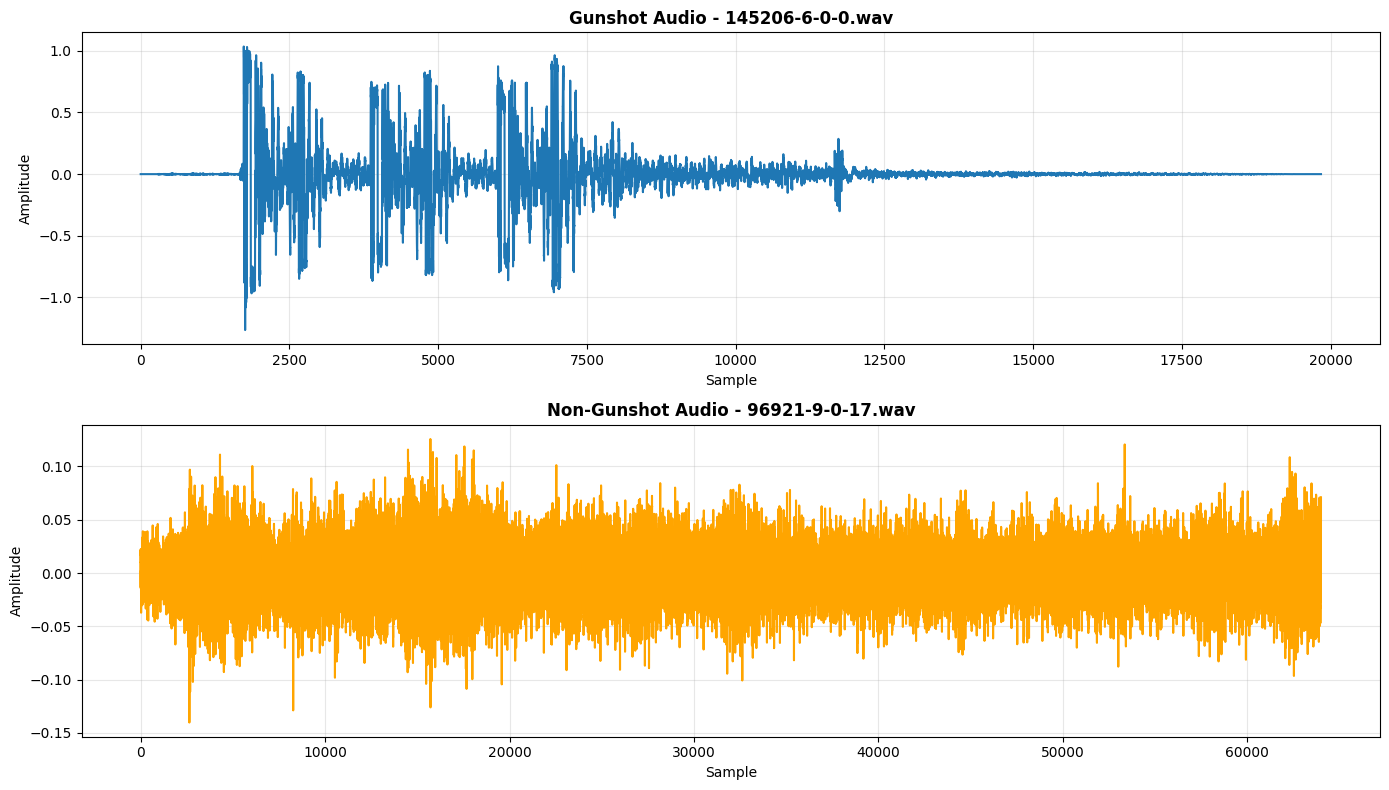

Gunshot duration: 1.24 seconds
Non-gunshot duration: 4.00 seconds


In [18]:
# Plot waveforms for gunshot vs non-gunshot samples
import random

# Randomly select files each time the cell runs
random_gunshot = random.choice(gunshot_files)
random_non_gunshot = random.choice(non_gunshot_files)

# Load the randomly selected samples
sample_gunshot_plot = load_wav_16k_mono(str(random_gunshot))
sample_non_gunshot_plot = load_wav_16k_mono(str(random_non_gunshot))

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot gunshot waveform
axes[0].plot(sample_gunshot_plot.numpy())
axes[0].set_title(f"Gunshot Audio - {random_gunshot.name}", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Sample")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, alpha=0.3)

# Plot non-gunshot waveform
axes[1].plot(sample_non_gunshot_plot.numpy(), color='orange')
axes[1].set_title(f"Non-Gunshot Audio - {random_non_gunshot.name}", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Sample")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Gunshot duration: {len(sample_gunshot_plot) / 16000:.2f} seconds")
print(f"Non-gunshot duration: {len(sample_non_gunshot_plot) / 16000:.2f} seconds")